## Accessing GOES-16 data on Azure

The [GOES-R](https://www.goes-r.gov/) (Geostationary Operational Environmental Satellite) program images weather phenomena from a set of satellites in geostationary orbits.  The GOES-16 satellite is the first of four planned GOES-R satellites; GOES-16's orbit provides a view of the Americas. 

This notebook provides an example of accessing GOES-16 data from blob storage on Azure, including (1) finding the data file corresponding to a date and time, (2) retrieving that file from blob storage, and (3) opening the downloaded file using the [xarray](http://xarray.pydata.org/en/stable/) library, and (4) rendering the image.

This dataset is stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-goes16](http://aka.ms/ai4edata-goes16).

### Environment setup

In [4]:
import os
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt

import xarray
import xarray.ufuncs as xu
from azure.storage.blob import ContainerClient

temp_dir = os.path.join(tempfile.gettempdir(),'goes')
os.makedirs(temp_dir,exist_ok=True)

In [5]:
xarray.__version__

'0.17.0'

In [6]:
import metpy
metpy.__version__

'1.0.1'

### Constants

In [15]:
# Choose a specific product, day, and time to analyze
product = 'ABI-L2-MCMIPF'
syear = '2020'; sday = '002'; shour = '14'

# Storage locations are documented at http://aka.ms/ai4edata-goes16
storage_account_name = 'goes'
container_name = 'noaa-goes16'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net'
goes_blob_root = storage_account_url + '/' + container_name + '/'

# Create a ContainerClient to enumerate blobs
goes_container_client = ContainerClient(account_url=storage_account_url, 
                                         container_name=container_name,
                                         credential=None)

### Functions

In [12]:
# Download a URL to a temporary file
def download_url(url):
    url_as_filename = url.replace('://', '_').replace('/', '_')    
    destination_filename = os.path.join(temp_dir,url_as_filename)
    urllib.request.urlretrieve(url, destination_filename)  
    return destination_filename

In [13]:
def calc_latlon(ds):
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

### Find images matching our specified product, date, and time

In [16]:
prefix = product + '/' + syear + '/' + sday + '/' + shour + '/'
print('Finding blobs matching prefix: {}'.format(prefix))
generator = goes_container_client.list_blobs(name_starts_with=prefix)
blobs = []
for blob in generator:
    blobs.append(blob.name)
print('Found {} images'.format(len(blobs)))

# There will be several scans this hour, we'll take the first
image_index = 0
url = goes_blob_root + blobs[image_index]
print('Processing image:\n{}'.format(url))

Finding blobs matching prefix: ABI-L2-MCMIPF/2020/002/14/
Found 6 images
Processing image:
https://goes.blob.core.windows.net/noaa-goes16/ABI-L2-MCMIPF/2020/002/14/OR_ABI-L2-MCMIPF-M6_G16_s20200021400218_e20200021409537_c20200021410039.nc


### Load the image

In [8]:
# GOES-16 MCMIPF files are ~300MB.  Not too big to fit in memory, so sometimes it may be 
# preferable to download to file first, sometimes it will be better to load straight to 
# memory.
download_to_file = True

if download_to_file:
    
    filename = download_url(url)
    dataset = xarray.open_dataset(filename)    

else:
    
    import netCDF4
    import requests
    
    response = requests.get(url)
    nc4_ds = netCDF4.Dataset(os.path.basename(url), memory=response.content)
    store = xarray.backends.NetCDF4DataStore(nc4_ds)
    dataset = xarray.open_dataset(store)

print('Scan starts at: {}'.format(dataset.time_coverage_start))
print('Scan ends at: {}'.format(dataset.time_coverage_end))

Scan starts at: 2020-01-02T14:00:21.8Z
Scan ends at: 2020-01-02T14:09:53.7Z


### Prepare to plot the image

In [9]:
# Bands are documented at:
#
# https://www.ncdc.noaa.gov/data-access/satellite-data/goes-r-series-satellites/glossary
#
# We'll use the red/"veggie"/blue bands with wavelengths 0.64, 0.86, and 0.47, respectively.
#
# This is close enough to RGB for today, but there's a great tutorial on getting closer to
# true color (and doing other fancy rendering tricks with GOES data!) here:
#
# https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html
#
r = dataset['CMI_C02'].data; r = np.clip(r, 0, 1)
g = dataset['CMI_C03'].data; g = np.clip(g, 0, 1)
b = dataset['CMI_C01'].data; b = np.clip(r, 0, 1)

# Brighten the image a bit for to look more stylish
gamma = 2.5; r = np.power(r, 1/gamma); g = np.power(g, 1/gamma); b = np.power(b, 1/gamma)

# Create a single RGB image for plotting
rgb = np.dstack((r, g, b))

### Plot the image

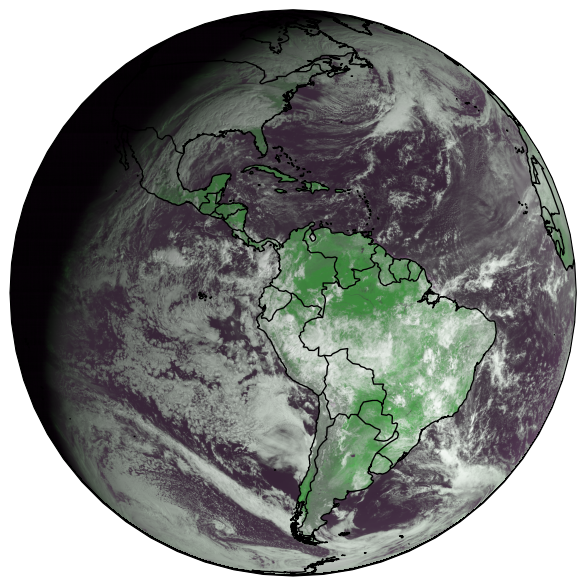

In [10]:
fig = plt.figure(figsize=(7.5, 7.5), dpi=100)

# This definitely looks slicker with fancy borders on, at the cost of some extra
# imports.
show_fancy_borders = True

if not show_fancy_borders:
    
    plt.imshow(rgb); ax = plt.gca(); ax.axis('off');

else:
    
    import metpy
    import cartopy.crs as ccrs

    # Pick an arbitrary channel to get the x/y coordinates and projection information 
    # associated with the scan
    dummy_channel = dataset.metpy.parse_cf('CMI_C01')
    x = dummy_channel.x; y = dummy_channel.y

    ax = fig.add_subplot(1, 1, 1, projection=dummy_channel.metpy.cartopy_crs)
    ax.imshow(rgb, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()))
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(ccrs.cartopy.feature.BORDERS);

### Plot with lat/lon box

### Add lat/lon

In [11]:
dataset = calc_latlon(dataset)

<ipython-input-6-7724a1894034>:18: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [12]:
lat1, lat2 = 21, 43
lon1, lon2 = -84, -56

In [13]:
# Bands are documented at:
#
# https://www.ncdc.noaa.gov/data-access/satellite-data/goes-r-series-satellites/glossary
#
# We'll use the red/"veggie"/blue bands with wavelengths 0.64, 0.86, and 0.47, respectively.
#
# This is close enough to RGB for today, but there's a great tutorial on getting closer to
# true color (and doing other fancy rendering tricks with GOES data!) here:
#
# https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html
#
r = dataset['CMI_C02'].clip(0,1)
g = dataset['CMI_C03'].clip(0, 1)
b = dataset['CMI_C01'].clip(0, 1)

# Brighten the image a bit for to look more stylish
gamma = 2.5; r=r**(1/gamma); g = g**(1/gamma); b = b**(1/gamma)

# Create a single RGB image for plotting
rgb = xarray.merge((r,g,b))

In [15]:
subset = rgb.where((rgb.lat >= lat1) & (rgb.lat <= lat2) & (rgb.lon >= lon1) & (rgb.lon <= lon2), drop=True)

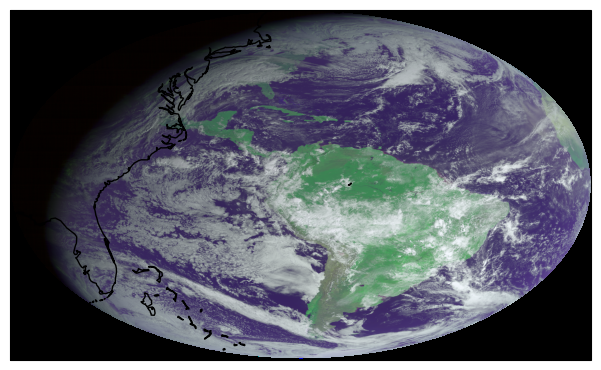

In [24]:
fig = plt.figure(figsize=(7.5, 7.5), dpi=100)

# This definitely looks slicker with fancy borders on, at the cost of some extra
# imports.
show_fancy_borders = True

if not show_fancy_borders:
    
    plt.imshow(rgb); ax = plt.gca(); ax.axis('off');

else:
    r = rgb["CMI_C02"]; g = rgb["CMI_C03"]; b = rgb["CMI_C01"]
    
    import metpy
    import cartopy.crs as ccrs

    # Pick an arbitrary channel to get the x/y coordinates and projection information 
    # associated with the scan
#     dummy_channel = dataset.where((dataset.lat >= lat1) & (dataset.lat <= lat2) & (dataset.lon >= lon1) & (dataset.lon <= lon2)).parse_cf("CMI_01")
    dummy_channel = subset
    x = dummy_channel.lon; y = dummy_channel.lat

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.imshow(np.dstack((r,g,b)), origin="upper",extent=(x.min(), x.max(), y.min(), y.max()))
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(ccrs.cartopy.feature.BORDERS);

In [19]:
rgb

<xarray.Dataset>
Dimensions:  (x: 5424, y: 5424)
Coordinates:
    t        datetime64[ns] 2020-01-02T14:05:07.767240960
  * y        (y) float32 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float32 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518
    y_image  float32 0.0
    x_image  float32 0.0
    lat      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    CMI_C02  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    CMI_C03  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    CMI_C01  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

### Clean up temporary files

In [14]:
shutil.rmtree(temp_dir)